In [24]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy as sp

In [3]:
# 구 형태의 데이터셋 생성
def create_sphere(cx,cy,cz,r,n):
    phi = np.random.uniform(0, 2*np.pi, size = n)
    theta = np.random.uniform(0, np.pi, size = n)
    
    r_xy = r*np.sin(theta)
    x = cx + np.cos(phi) * r_xy
    
    y = cy + np.sin(phi) * r_xy
    
    z = cz + r * np.cos(theta)
    
    return np.stack([x,y,z])

In [4]:
#(0,0,0)이 중심이고 반지름이 100인 구 위의 1000개의 데이터(Class1)
sphere1 = create_sphere(0, 0, 0, 100, 1000) 

In [10]:
sphere1

array([[-56.57330526,  40.92464168,   1.59900755, ...,  53.44523218,
         72.78841822,  -0.82614169],
       [-79.73340326,  -3.77426042,  -0.52951572, ..., -31.80764708,
        -61.42337186,  48.41484059],
       [ 21.024879  ,  91.16429488, -99.98581293, ...,  78.30632634,
         30.47975658,  87.49468956]])

In [8]:
#(0,0,0)이 중심이고 반지름이 40인 구 위의 200개 데이터(Class2)
sphere2 = create_sphere(0, 0, 0, 40,1000)
print(np.shape(sphere1))
print(np.shape(sphere2))

(3, 1000)
(3, 1000)


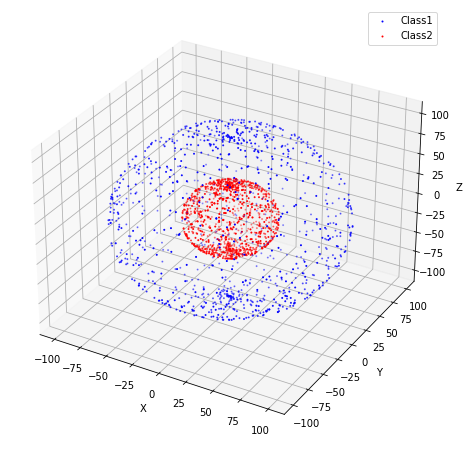

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sphere1[0,:],sphere1[1,:],sphere1[2,:], c='b', s=1, label='Class1')
ax.scatter(sphere2[0,:],sphere2[1,:],sphere2[2,:], c='r', s=1, label='Class2')
ax.set_xlabel("X")
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

In [13]:
# 데이터 결합 및 정제
X1_1 = sphere1[0,:]
X2_1 = sphere1[1,:]
X3_1 = sphere1[2,:]
Y_1 = 100
X1_2 = sphere2[0,:]
X2_2 = sphere2[1,:]
X3_2 = sphere2[2,:]
Y_2 = 40
X1 = np.concatenate((X1_1,X1_2), axis=0)
X2 = np.concatenate((X2_1,X2_2), axis=0)
X3 = np.concatenate((X3_1,X3_2), axis=0)
X = np.vstack((X1, X2, X3))
y = np.zeros(np.shape(X)[1])
y[:1000] = Y_1
y[1000:] = Y_2
data = np.vstack((X, y))
data = pd.DataFrame(data).T
data.columns=["X1", "X2", "X3", "y"]
X = data[["X1","X2","X3"]]
y = data["y"]

In [14]:
X

,X1,X2,X3
0,-56.573305,-79.733403,21.024879
1,40.924642,-3.774260,91.164295
2,1.599008,-0.529516,-99.985813
3,13.108093,-10.422580,98.587767
4,73.684668,59.018452,32.975627
...,...,...,...
1995,-21.740054,22.185681,25.202492
1996,13.261801,-19.267137,-32.448452
1997,5.404605,-9.305780,38.525222
1998,-29.223604,10.070138,-25.388448


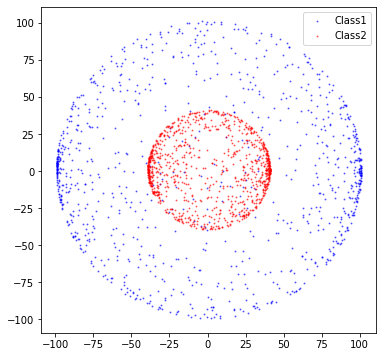

In [15]:
# Standard(Linear) PCA
from sklearn.decomposition import PCA
linear_pca = PCA(n_components=2)
linear_pca.fit(X)
pca_X = linear_pca.transform(X)
x1 = pca_X[:,0]
x2 = pca_X[:,1]
plt.figure(figsize=(6,6))
plt.scatter(x1[y==100], x2[y==100], c='b', alpha=0.5, s=1, label='Class1')
plt.scatter(x1[y==40], x2[y==40], c='r', alpha=0.5, s=1, label='Class2')
plt.legend()
plt.show()

<ipython-input-30-c5a78cafacae>:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))


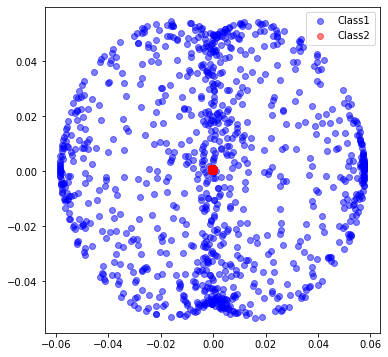

In [30]:
# Kernel PCA with Polynomial kernel
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
def poly_kpca(X, degree, n_components, coef0=1):
    K = (np.dot(X, X.T) + coef0) ** degree
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    eigvals, eigvecs = eigh(K)
    pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    return pc
pc = poly_kpca(X, 5, 2) #degree=5로 설정
x1 = pc[:,0]
x2 = pc[:,1]
plt.figure(figsize=(6,6))
plt.scatter(x1[y==100], x2[y==100], c='b', alpha=0.5, label='Class1')
plt.scatter(x1[y==40], x2[y==40], c='r', alpha=0.5, label='Class2')
plt.legend()
plt.show()

<ipython-input-32-c1574cebd70c>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))


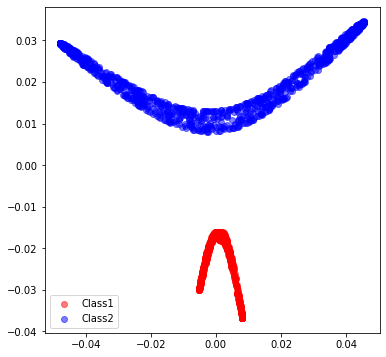

In [32]:
# Kernel PCA with Gaussian kernel
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
def rbf_kpca(X, gamma, n_components):
    distance = pdist(X, 'sqeuclidean')  #샘플 간 유클리디안 거리^2
    pairwise_distance = squareform(distance)  #거리를 정방대칭행렬로 변환
    K = np.exp(-pairwise_distance / (2 * (gamma**2)))  #커널 행렬 계산
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n) #커널 행렬을 중앙에 맞춤
    eigvals, eigvecs = eigh(K)  #커널행렬의 고유값, 고유벡터를 오름차순으로 반환
    pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    return pc
pc = rbf_kpca(X, gamma=27.8, n_components=2) #gamma=27.8으로 설정
x1 = pc[:,0]
x2 = pc[:,1]
plt.figure(figsize=(6,6))
plt.scatter(x1[y==100], x2[y==100], c='r', alpha=0.5, label='Class1')
plt.scatter(x1[y==40], x2[y==40], c='b', alpha=0.5, label='Class2')
plt.legend()
plt.show()